![title](http://www.sas.com/content/sascom/en_us/software/viya/_jcr_content/par/styledcontainer_95fa/par/image_e693.img.png/1473452935247.png)

# A simple pipeline using hypergroup to perform community detection and network analysis

A social network of a [karate club](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) was studied by Wayne W. Zachary [1] for a period of three years from 1970 to 1972. The network captures 34 members of a karate club, documenting 78 pairwise links between members who interacted outside the club. During the study a conflict arose between the administrator "John A" and instructor "Mr. Hi" (pseudonyms), which led to the split of the club into two. Half of the members formed a new club around Mr. Hi, members from the other part found a new instructor or gave up karate. Basing on collected data Zachary assigned correctly all but one member of the club to the groups they actually joined after the split.

[1] W. Zachary, An information flow model for conflict and fission in small groups, Journal of Anthropological Research 33, 452-473 (1977)

## Data Preparation
### Import packages:   SAS Wrapper for Analytic Transfer and open source libraries

In [1]:
import swat
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

# Also import networkx used for rendering a network
import networkx as nx

%matplotlib inline

### Connect to Cloud Analytic Services in SAS Viya

In [2]:
s = swat.CAS('http://cas.mycompany.com:8888') # REST API

### Load the action set for hypergroup

In [3]:
s.loadactionset('hypergroup')

NOTE: Added action set 'hypergroup'.


[actionset]

 'hypergroup'

+ Elapsed: 0.0164s, user: 0.015s, sys: 0.001s, mem: 0.259mb

### Load data into CAS

Data set used from https://en.wikipedia.org/wiki/Zachary%27s_karate_club.

In [4]:
df = pd.DataFrame.from_records([[2,1],[3,1],[3,2],[4,1],[4,2],[4,3],[5,1],[6,1],[7,1],[7,5],[7,6],[8,1],[8,2],[8,3],[8,4],[9,1],[9,3],[10,3],[11,1],[11,5],[11,6],[12,1],[13,1],[13,4],[14,1],[14,2],[14,3],[14,4],[17,6],[17,7],[18,1],[18,2],[20,1],[20,2],[22,1],[22,2],[26,24],[26,25],[28,3],[28,24],[28,25],[29,3],[30,24],[30,27],[31,2],[31,9],[32,1],[32,25],[32,26],[32,29],[33,3],[33,9],[33,15],[33,16],[33,19],[33,21],[33,23],[33,24],[33,30],[33,31],[33,32],[34,9],[34,10],[34,14],[34,15],[34,16],[34,19],[34,20],[34,21],[34,23],[34,24],[34,27],[34,28],[34,29],[34,30],[34,31],[34,32],[34,33]],
                                columns=['FROM','TO'])
df['SOURCE'] = df['FROM'].astype(str)
df['TARGET'] = df['TO'].astype(str)
df.head()

,FROM,TO,SOURCE,TARGET
0,2,1,2,1
1,3,1,3,1
2,3,2,3,2
3,4,1,4,1
4,4,2,4,2


**Hypergroup** doesn't support numeric source and target columns - so make sure to cast them as varchars.

In [5]:
if s.tableexists('karate').exists:
    s.CASTable('KARATE').droptable()

dataset = s.upload(df,
                   importoptions=dict(filetype='csv', 
                                      vars=[dict(type='double'),
                                            dict(type='double'),
                                            dict(type='varchar'), 
                                            dict(type='varchar')]),
                   casout=dict(name='KARATE', promote=True)).casTable

NOTE: Cloud Analytic Services dropped table KARATE from caslib CASUSER(kesmit).
NOTE: Cloud Analytic Services made the uploaded file available as table KARATE in caslib CASUSER(kesmit).
NOTE: The table KARATE has been created in caslib CASUSER(kesmit) from binary data uploaded to Cloud Analytic Services.


## Data Exploration

### Get to know your data (what are variables?)

In [6]:
dataset.head(5)

,FROM,TO,SOURCE,TARGET
0,2.0,1.0,2,1
1,3.0,1.0,3,1
2,3.0,2.0,3,2
3,34.0,23.0,34,23
4,4.0,1.0,4,1


In [7]:
dataset.summary()

,Column,Min,Max,N,NMiss,Mean,Sum,Std,StdErr,Var,USS,CSS,CV,TValue,ProbT
0,FROM,2.0,34.0,78.0,0.0,22.423077,1749.0,11.506654,1.302872,132.403097,49413.0,10195.038462,51.316126,17.210498,4.131705e-28
1,TO,1.0,33.0,78.0,0.0,12.076923,942.0,11.267433,1.275786,126.955045,21152.0,9775.538462,93.297215,9.466264,1.519630e-14


### Graph rendering utility

In [8]:
def renderNetworkGraph(filterCommunity=-1, size=18, sizeVar='_HypGrp_', 
                       colorVar='', sizeMultipler=500, nodes_table='nodes', 
                       edges_table='edges'):
    ''' Build an array of node positions and related colors based on community '''
    nodes = s.CASTable(nodes_table)
    if filterCommunity >= 0:
        nodes = nodes.query('_Community_ EQ %F' % filterCommunity)
    nodes = nodes.to_frame()

    nodePos = {}
    nodeColor = {}
    nodeSize = {}
    communities = []
    i = 0
    for nodeId in nodes._Value_:    
        nodePos[nodeId] = (nodes._AllXCoord_[i], nodes._AllYCoord_[i])
        if colorVar: 
            nodeColor[nodeId] = nodes[colorVar][i]
            if nodes[colorVar][i] not in communities:
                communities.append(nodes[colorVar][i])
        nodeSize[nodeId] = max(nodes[sizeVar][i],0.1)*sizeMultipler
        i += 1
    communities.sort()
  
    # Build a list of source-target tuples
    edges = s.CASTable(edges_table)
    if filterCommunity >= 0:
        edges = edges.query('_SCommunity_ EQ %F AND _TCommunity_ EQ %F' % 
                            (filterCommunity, filterCommunity))
    edges = edges.to_frame()

    edgeTuples = []
    for i, p in enumerate(edges._Source_):
        edgeTuples.append( (edges._Source_[i], edges._Target_[i]) )
    
    # Add nodes and edges to the graph
    plt.figure(figsize=(size,size))
    graph = nx.DiGraph()
    graph.add_edges_from(edgeTuples)

    # Size mapping
    getNodeSize=[nodeSize[v] for v in graph]
    
    # Color mapping
    jet = cm = plt.get_cmap('jet')
    getNodeColor=None
    if colorVar: 
        getNodeColor=[nodeColor[v] for v in graph]
        cNorm  = colors.Normalize(vmin=min(communities), vmax=max(communities))
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    
        # Using a figure here to work-around the fact that networkx doesn't 
        # produce a labelled legend
        f = plt.figure(1)
        ax = f.add_subplot(1,1,1)
        for community in communities:
            ax.plot([0],[0], color=scalarMap.to_rgba(community), 
                    label='Community %s' % '{:2.0f}'.format(community), linewidth=10)
        
    # Render the graph
    nx.draw_networkx_nodes(graph, nodePos, node_size=getNodeSize, 
                           node_color=getNodeColor, cmap=jet)
    nx.draw_networkx_edges(graph, nodePos, width=1, alpha=0.5)
    nx.draw_networkx_labels(graph, nodePos, font_size=11, font_family='sans-serif')
        
    if len(communities) > 0:
        plt.legend(loc='upper left', prop={'size':11})
        
    plt.title('Zachary Karate Club social network', fontsize=30)
    plt.axis('off')
    plt.show()

### Execute community and hypergroup detection

In [9]:
# Create output table objects
edges = s.CASTable('edges', replace=True)
nodes = s.CASTable('nodes', replace=True)

dataset[['SOURCE', 'TARGET']].hyperGroup(
    createOut = 'never',
    allGraphs = True,
    edges     = edges,
    vertices  = nodes
)

,casLib,Name,Rows,Columns,casTable
0,CASUSER(kesmit),edges,78,19,"CASTable('edges', caslib='CASUSER(kesmit)')"
1,CASUSER(kesmit),nodes,34,9,"CASTable('nodes', caslib='CASUSER(kesmit)')"


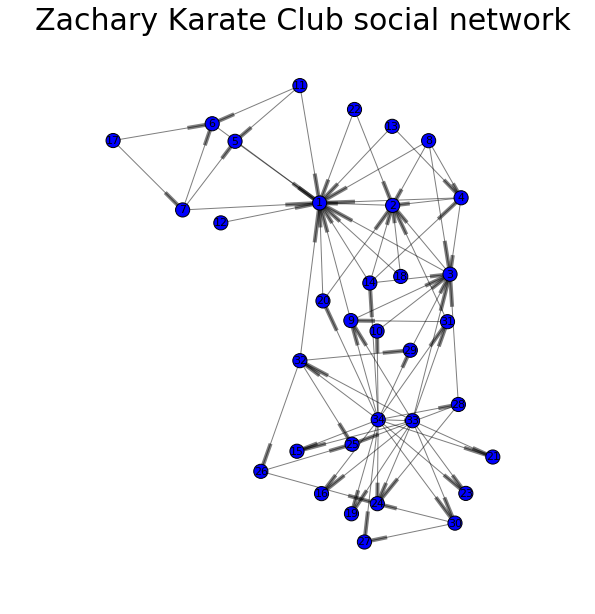

In [10]:
renderNetworkGraph(size=10, sizeMultipler=2000)

>**Note:** Network of the Zachary Karate Club. Distribution by degree of the node. Node 1 stands for the instructor, node 34 for the president

In [11]:
dataset[['SOURCE', 'TARGET']].hyperGroup(
    createOut = 'never',
    allGraphs = True,
    community = True,
    edges     = edges,
    vertices  = nodes
)

,casLib,Name,Rows,Columns,casTable
0,CASUSER(kesmit),edges,78,21,"CASTable('edges', caslib='CASUSER(kesmit)')"
1,CASUSER(kesmit),nodes,34,10,"CASTable('nodes', caslib='CASUSER(kesmit)')"


How many hypergroups and communities do we have?

In [12]:
nodes.distinct()

,Column,NDistinct,NMiss,Trunc
0,_HypGrp_,1.0,0.0,0.0
1,_Value_,34.0,0.0,0.0
2,_Index_,34.0,0.0,0.0
3,_IndexH_,34.0,0.0,0.0
4,_AllXCoord_,34.0,0.0,0.0
5,_AllYCoord_,34.0,0.0,0.0
6,_XCoord_,34.0,0.0,0.0
7,_YCoord_,34.0,0.0,0.0
8,_Color_,1.0,0.0,0.0
9,_Community_,3.0,0.0,0.0


In [13]:
nodes.summary()

,Column,Min,Max,N,NMiss,Mean,Sum,Std,StdErr,Var,USS,CSS,CV,TValue,ProbT
0,_HypGrp_,0.000000,0.000000,34.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
1,_Index_,0.000000,33.000000,34.0,0.0,16.500000,561.000000,9.958246,1.707825,99.166667,12529.000000,3272.500000,60.353007,9.661411,3.808328e-11
2,_IndexH_,0.000000,33.000000,34.0,0.0,16.500000,561.000000,9.958246,1.707825,99.166667,12529.000000,3272.500000,60.353007,9.661411,3.808328e-11
3,_AllXCoord_,22.781645,77.218355,34.0,0.0,57.289114,1947.829868,12.775281,2.190943,163.207798,116975.304237,5385.857349,22.299666,26.148159,1.233624e-23
4,_AllYCoord_,17.283506,82.716494,34.0,0.0,49.178759,1672.077822,20.381366,3.495375,415.400089,95938.915968,13708.202933,41.443433,14.069664,1.690800e-15
5,_XCoord_,22.781645,77.218355,34.0,0.0,57.289114,1947.829868,12.775281,2.190943,163.207798,116975.304237,5385.857349,22.299666,26.148159,1.233624e-23
6,_YCoord_,17.283506,82.716494,34.0,0.0,49.178759,1672.077822,20.381366,3.495375,415.400089,95938.915968,13708.202933,41.443433,14.069664,1.690800e-15
7,_Color_,0.000000,0.000000,34.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
8,_Community_,0.000000,2.000000,34.0,0.0,0.647059,22.000000,0.733706,0.125830,0.538324,32.000000,17.764706,113.390920,5.142345,1.212431e-05


### Basic community analysis

What are the 2 biggest communities?

In [14]:
topKOut = s.CASTable('topKOut', replace=True)

nodes[['_Community_']].topk(
    aggregator = 'N',
    topK       = 4,
    casOut     = topKOut
)

topKOut = topKOut.sort_values('_Rank_').head(10)
topKOut.columns

Index(['_Column_', '_Fmtvar_', '_Rank_', '_Score_'], dtype='object')

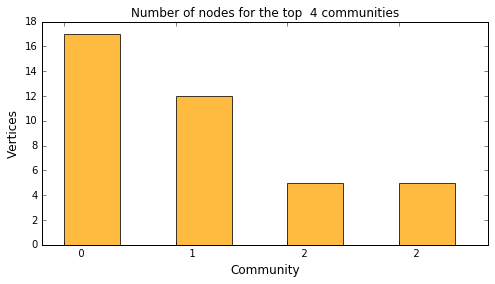

In [15]:
nCommunities = len(topKOut)

ind = np.arange(nCommunities)    # the x locations for the groups

plt.figure(figsize=(8,4))
p1 = plt.bar(ind + 0.2, topKOut._Score_, 0.5, color='orange', alpha=0.75)

plt.ylabel('Vertices', fontsize=12)
plt.xlabel('Community', fontsize=12)
plt.title('Number of nodes for the top %s communities' % '{:2.0f}'.format(nCommunities))
plt.xticks(ind + 0.2, topKOut._Fmtvar_)

plt.show()

>**Note:** This shows that the biggest communities have up to 18 vertices.

What nodes belong to community 4?

In [16]:
nodes.query('_Community_ EQ 1').head(5)

,_HypGrp_,_Value_,_Index_2,_IndexH_,_AllXCoord_,_AllYCoord_,_XCoord_,_YCoord_,_Color_,_Community_
0,0.0,15,6.0,14.0,49.141918,30.294436,49.141918,30.294436,0.0,1.0
1,0.0,16,7.0,13.0,52.662150,24.219019,52.662150,24.219019,0.0,1.0
2,0.0,19,10.0,12.0,56.957410,21.330565,56.957410,21.330565,0.0,1.0
3,0.0,21,13.0,11.0,77.218355,29.467282,77.218355,29.467282,0.0,1.0
4,0.0,23,15.0,10.0,73.352523,24.251782,73.352523,24.251782,0.0,1.0


What edges do we have?

In [17]:
edges.head(5)

,_HypGrp_,_Source_,_Target_,_Sindex_,_Tindex_,_SindexH_,_TindexH_,_AllSourceX_,_AllSourceY_,_AllTargetX_,...,_SourceX_,_SourceY_,_TargetX_,_TargetY_,_SColor_,_TColor_,_SCommunity_,_TCommunity_,FROM,TO
0,0.0,5,1,29.0,0.0,22.0,0.0,40.262209,74.728537,52.387480,...,40.262209,74.728537,52.387480,65.891710,0.0,0.0,2.0,0.0,5.0,1.0
1,0.0,6,1,30.0,0.0,21.0,0.0,36.989588,77.249461,52.387480,...,36.989588,77.249461,52.387480,65.891710,0.0,0.0,2.0,0.0,6.0,1.0
2,0.0,7,1,31.0,0.0,19.0,0.0,32.749605,64.891412,52.387480,...,32.749605,64.891412,52.387480,65.891710,0.0,0.0,2.0,0.0,7.0,1.0
3,0.0,34,27,27.0,19.0,2.0,8.0,60.790407,34.815954,58.812846,...,60.790407,34.815954,58.812846,17.283506,0.0,0.0,1.0,1.0,34.0,27.0
4,0.0,34,20,27.0,12.0,2.0,27.0,60.790407,34.815954,52.868892,...,60.790407,34.815954,52.868892,51.842244,0.0,0.0,1.0,0.0,34.0,20.0


### Render the network graph

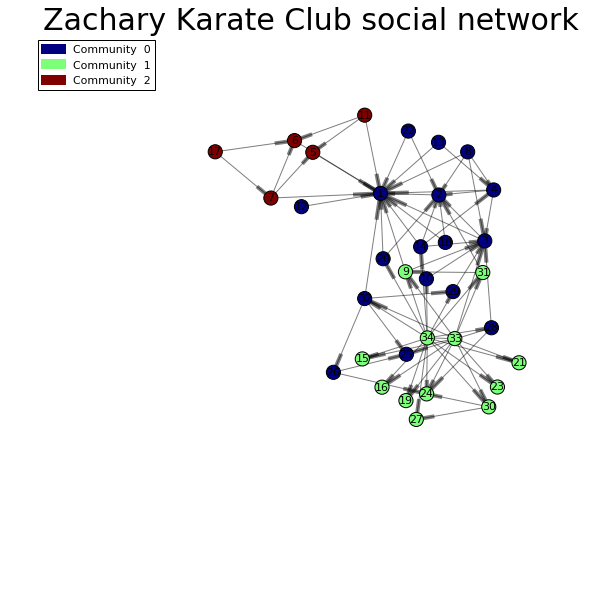

In [18]:
renderNetworkGraph(size=10, colorVar='_Community_', sizeMultipler=2000)

### Analyze node centrality

How important is a user in the network?

In [19]:
dataset[['SOURCE', 'TARGET']].hyperGroup(
    createOut = 'never',
    community = True,
    centrality = True,
    mergeCommSmallest = True,
    allGraphs = True,
    graphPartition = True,
    scaleCentralities = 'central1', # Returns centrality values closer to 1 in the center
    edges     = edges,
    vertices  = nodes
)

,casLib,Name,Rows,Columns,casTable
0,CASUSER(kesmit),edges,78,33,"CASTable('edges', caslib='CASUSER(kesmit)')"
1,CASUSER(kesmit),nodes,34,16,"CASTable('nodes', caslib='CASUSER(kesmit)')"


In [20]:
nodes.head()

,_HypGrp_,_Value_,_Index_2,_IndexH_,_AllXCoord_,_AllYCoord_,_XCoord_,_YCoord_,_Color_,_Community_,_Reach_,_Stress_,_Closeness_,_Betweenness_,_CentroidMag_,_CentroidAngle_
0,0.0,1,0.0,0.0,52.387480,65.891710,52.387480,65.891710,0.0,0.0,3.0,0.852234,1.000000,0.841033,17.416910,343.646723
1,0.0,10,1.0,15.0,60.625389,47.517593,60.625389,47.517593,0.0,0.0,4.0,0.945017,0.689655,0.908564,3.726957,116.623096
2,0.0,11,2.0,33.0,49.564706,82.716494,49.564706,82.716494,0.0,2.0,4.0,0.563574,0.500000,0.398798,34.415783,347.095422
3,0.0,12,3.0,32.0,38.228319,63.035964,38.228319,63.035964,0.0,0.0,4.0,0.553265,0.448276,0.382094,23.565568,306.143115
4,0.0,13,4.0,31.0,62.795477,76.877460,62.795477,76.877460,0.0,0.0,4.0,0.467354,0.465517,0.335769,28.240717,11.142467


Between-ness centrality quantifies the number of times a node acts as a bridge along the shortest path(s) between two other nodes. As such it describes the importance of a node in a network.

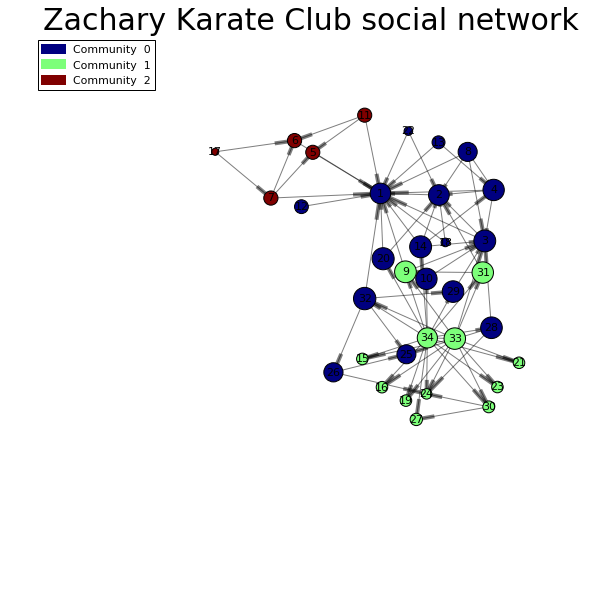

In [21]:
renderNetworkGraph(size=10, colorVar='_Community_', sizeVar='_Betweenness_')

### Filter communities

Only filter community 2.

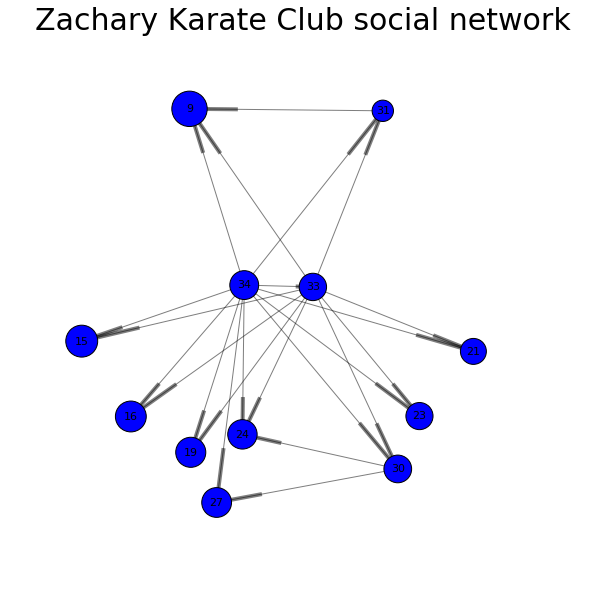

In [22]:
renderNetworkGraph(1, size=10, sizeVar='_CentroidAngle_', sizeMultipler=5)

In [23]:
s.close()

>Falko Schulz ▪ Principal Software Developer ▪ Business Intelligence Visualization R&D ▪ SAS® Institute ▪ [falko.schulz@sas.com](mailto:falko.schulz@sas.com) ▪ http://www.sas.com